In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid", {"grid.color": ".6",
						"grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [3]:
# read dataset using pndas function
# use parse_dates argument to change datetime dtype
dataset = pd.read_csv(r"C:\Users\Gustav\Desktop\Projects\Gold Price\gold_price_data.csv", parse_dates=["Date"])

In [4]:
# information about the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     2290 non-null   datetime64[ns]
 1   SPX      2290 non-null   float64       
 2   GLD      2290 non-null   float64       
 3   USO      2290 non-null   float64       
 4   SLV      2290 non-null   float64       
 5   EUR/USD  2290 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 107.5 KB


In [5]:
# Missing Values/Null Values Count
dataset.isna().sum().sort_values(ascending=False)

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

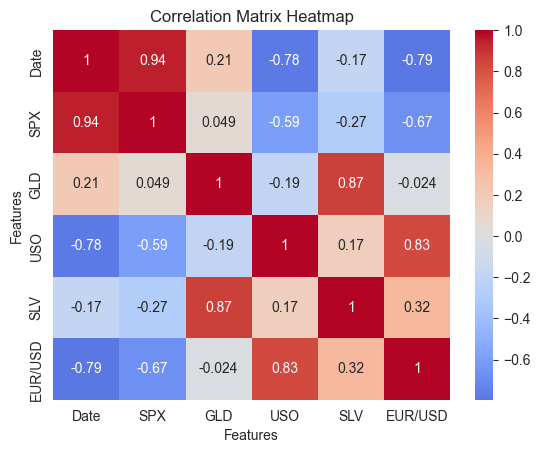

In [6]:
# Calculate correlation matrix
correlation = dataset.corr()

# Create heatmap
sns.heatmap(correlation, cmap='coolwarm',
			center=0, annot=True)

# Set title and axis labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

# Show plot
plt.show()

Here the two columns SLV and GLD are strongly correlated with each other compared to others, here it was decieded to drop SLV since GLD column also has a large correlation with our target column.

In [7]:
# drop SlV column
dataset.drop("SLV", axis=1,
			inplace=True)

In [ ]:
# reset the index to date column
dataset.set_index("Date", inplace=True)

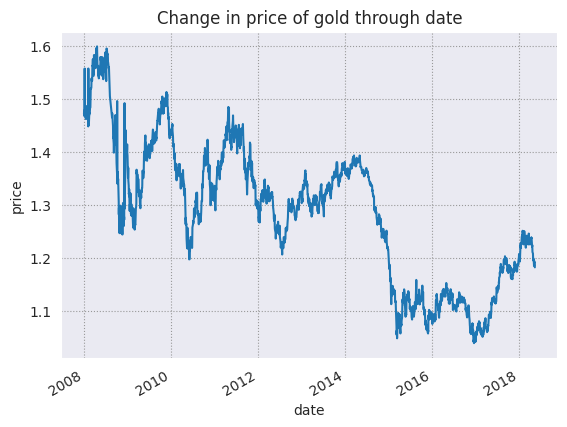

In [ ]:
# plot price of gold for each increasing day
dataset["EUR/USD"].plot()
plt.title("Change in price of gold through date")
plt.xlabel("date")
plt.ylabel("price")
plt.show()

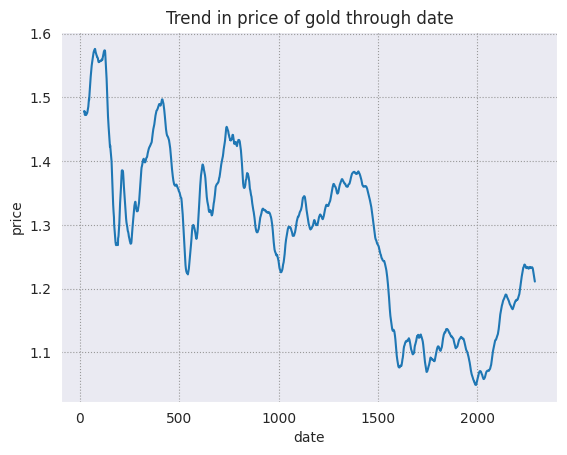

In [ ]:
# apply rolling mean with window size of 3
dataset["price_trend"] = dataset["EUR/USD"]\
	.rolling(window=20).mean()

# reset the index to date column
dataset.reset_index("Date", inplace=True)

# since we have used rolling method
# for 20 rows first 2 rows will be NAN
dataset["price_trend"].loc[20:].plot()

# set title of the chart
plt.title("Trend in price of gold through date")

# set x_label of the plot
plt.xlabel("date")
plt.ylabel("price")
plt.show()

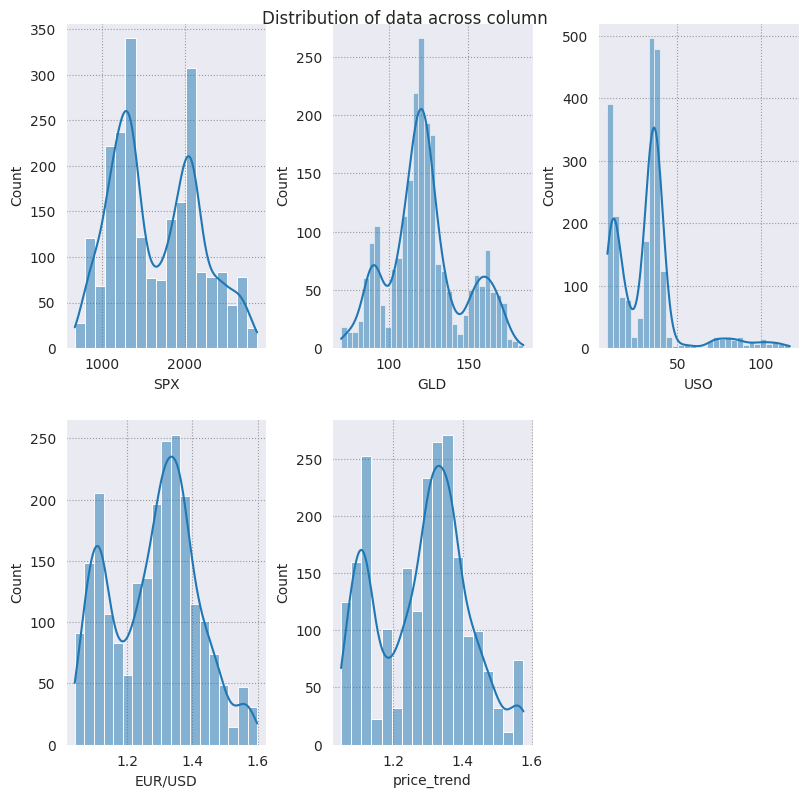

In [ ]:
fig = plt.figure(figsize=(8, 8))

# suptitle of the graph
fig.suptitle('Distribution of data across column')
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
	plt.subplot(2, 3, i+1)
	sns.histplot(data=dataset, x=item, kde=True)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [ ]:
# skewness along the index axis
print(dataset.drop("Date", axis=1).skew(axis=0, skipna=True))

SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64


In [ ]:
# apply saquare root transformation
# on the skewed dataset
dataset["USO"] = dataset["USO"].apply(lambda x: np.sqrt(x))

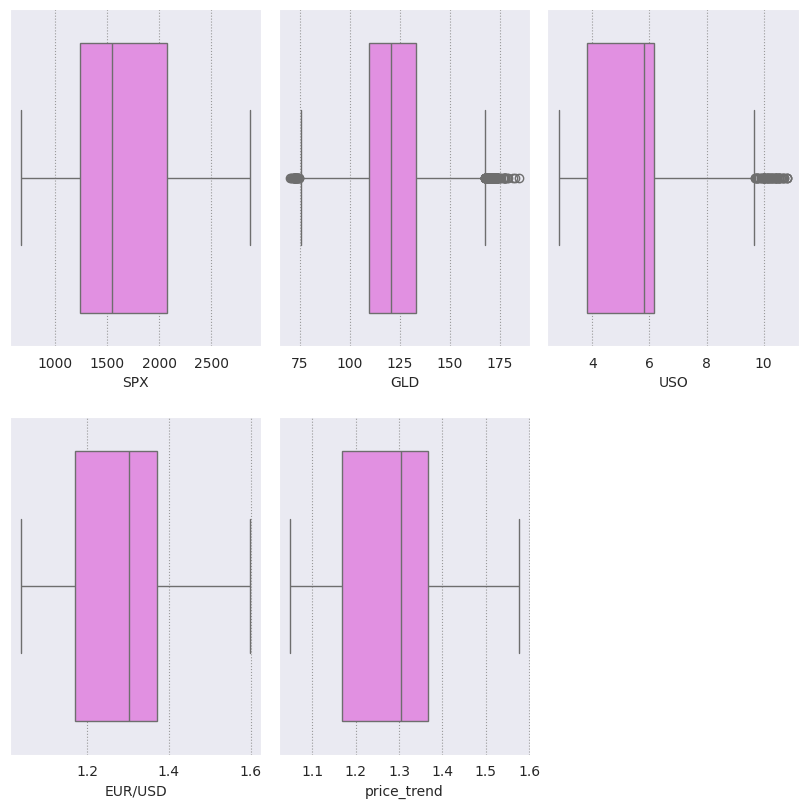

In [ ]:
fig = plt.figure(figsize=(8, 8))
temp = dataset.drop("Date", axis=1).columns.tolist()
for i, item in enumerate(temp):
	plt.subplot(2, 3, i+1)
	sns.boxplot(data=dataset, x=item, color='violet')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
plt.show()

In [ ]:
def outlier_removal(column):
	# Capping the outlier rows with Percentiles
	upper_limit = column.quantile(.95)
	# set upper limit to 95percentile
	lower_limit = column.quantile(.05)
	# set lower limit to 5 percentile
	column.loc[(column > upper_limit)] = upper_limit
	column.loc[(column < lower_limit)] = lower_limit
	return column

In [ ]:
# Normalize outliers in columns except Date

dataset[['SPX', 'GLD', 'USO', 'EUR/USD']] = dataset[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)

In [ ]:
# select the features and target variable
X = dataset.drop(['Date', 'EUR/USD'], axis=1)

y = dataset['EUR/USD']
# dividing dataset in to train test
x_train, x_test, y_train, y_test = train_test_split(X, y,
									test_size=0.2)

In [ ]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

# Transform the training dataset
# using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [ ]:
# Impute missing values using SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # Replace NaNs with the mean of each column

# Fit and transform the imputer on the scaled training data
x_train_scaled = imputer.fit_transform(x_train_scaled)

# Transform the scaled test data using the trained imputer
x_test_scaled = imputer.transform(x_test_scaled)

# Create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)

# Create a Lasso object
lasso = Lasso()

# Define a dictionary of parameter
#values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
							1e-1, 1, 5, 10,
							20, 30, 40]}

# Create a pipeline that first applies
# polynomial features and then applies Lasso regression
pipeline = make_pipeline(poly, lasso)

# Create a GridSearchCV object with
#the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline,
								param_grid,
								scoring='r2', cv=3)

# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train)

# Predict the target variable using
# the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_scaled)

# Compute the R-squared of the fitted model on the train data
r2 = r2_score(y_train, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ',
	lasso_grid_search.best_params_)
print('Best score: ',
	lasso_grid_search.best_score_)

R-squared:  0.9672083964521433
Best parameter values:  {'lasso__alpha': 0.0001}
Best score:  0.9667179840488848


In [ ]:
# Insiate param grid for which to search
param_grid = {'n_estimators': [50, 80, 100],
			'max_depth': [3, 5, 7]}

# create instance of the Randomforest regressor
rf = RandomForestRegressor()

# Define Girdsearch with random forest
# object parameter grid scoring and cv
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)

# Fit the GridSearchCV object to the training data

rf_grid_search.fit(x_train_scaled, y_train)

# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

Best parameter values:  {'max_depth': 7, 'n_estimators': 80}
Best score:  0.976178800252065


In [ ]:
# Compute the R-squared of the
# fitted model on the test data
r2 = r2_score(y_test,
			rf_grid_search.predict(x_test_scaled))

# Print the R-squared
print("R-squared:", r2)

R-squared: 0.9735958154503389


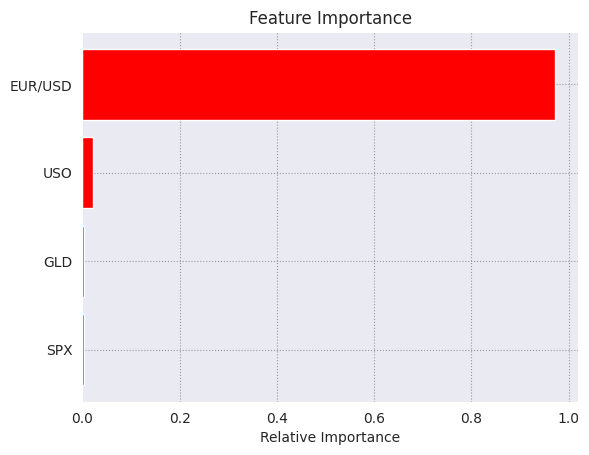

In [ ]:
features = dataset.drop("Date", axis=1).columns

# store the importance of the feature
importances = rf_grid_search.best_estimator_.feature_importances_


indices = np.argsort(importances)

# title of the graph
plt.title('Feature Importance')

plt.barh(range(len(indices)),
		importances[indices],
		color='red',
		align='center')

# plot bar chart
plt.yticks(range(len(indices)),
		[features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Create an instance of the XGBRegressor model
model_xgb = XGBRegressor()

# Fit the model to the training data
model_xgb.fit(x_train_scaled, y_train)

# Print the R-squared score on the training data
print("Xgboost Accuracy =", r2_score(
	y_train, model_xgb.predict(x_train_scaled)))

Xgboost Accuracy = 0.9995012181628151


In [ ]:
# Print the R-squared score on the test data
print("Xgboost Accuracy on test data =",
	r2_score(y_test,
			model_xgb.predict(x_test_scaled)))

Xgboost Accuracy on test data = 0.9842186135135597


In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.2.2
!pip install eli5

Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 92.0 MB/s eta 0:00:00


In [ ]:
import eli5 as eli
# weight of variables in xgboost model
# Get the names of the features
feature_names = x_train.columns.tolist()

# Explain the weights of the features using ELI5
eli.explain_weights(model_xgb,
					feature_names=feature_names)

Weight,Feature
0.9570,price_trend
0.0292,USO
0.0074,GLD
0.0064,SPX


In [ ]:
# dump model using pickle library
import pickle

# dump model in file model.pkl
pickle.dump(model_xgb, open('model.pkl', 'wb'))